# Datos y su procesamiento
Tratamiento y buen uso de datos para evitar "garbage in, garbage out", encontrar los datos con la maxima calidad de plataformas con la maxima confianza posible
Getting data from Yahoo Finance
Getting data from Quandl

El resultado de la solicitud es un DataFrame contiene los precios diarios de apertura, precios de apertura, alta, baja y cierre (OHLC: Open, High, Low, and Close), así como el precio de cierre ajustado y el volumen.


In [ ]:
# Descarga de datos sin hacer uso de API externa

import time
import datetime
import pandas as pd

ticker = "TSLA"
start_date = int(time.mktime(datetime.datetime(2020, 11, 1, 23,59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2021, 8, 1, 23,59).timetuple()))
interval = "1wk"

query_string = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true"

df = pd.read_csv(query_string)
print(df)

In [ ]:
# Usando la API de yahoo finance

import pandas as pd
import numpy as np
import yfinance as yf

df= yf.download("AAPL", 
    start = "2020-01-01", 
    end="2021-08-14",
    progress=False)

# Obteniendo especifiamente una columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de los retornos, usando los precios de cierre ajustados
df["simple_retorno"] = df.adj_close.pct_change()
df["log_retorno"] = np.log(df.adj_close/df.adj_close.shift(1))


print(df)

## Calculo de los retornos considerando la inflacion
Ecuacion: 

$$R_t^r=\frac{1+R_t}{1+\pi_t}-1$$ 


In [ ]:

# Importación de bibliotecas y autentificación
import quandl

QUANDL_KEY = ""
quandl.ApiConfig.api_key = QUANDL_KEY


In [ ]:
## Creacion de dataframe y union de precios

import pandas
import quandl

df_all_dates = pd.DataFrame(index= pd.date_range(
    start="2020-12-31",\
    end="2021-08-14"
    ))
df = df_all_dates.join(df[["adj_close"]], how="left")\
    .fillna(method="ffill")\
    .asfreq("M")

## Descarga de tasas de inflacion de Quandl
df_cpi = quandl.get(dataset="RATEINF/CPI_USA", \
    start_date="2020-12-31",
    end_date = "2021-08-14") # CPI: costumer price index
df_cpi.rename(columns={"Value":"cpi"}, inplace=True)

## Mezcla: datos inflacion con precios
df_merged = df.join(df_cpi, how="left")

## Calculo de los retornos simples y la tasa de inflacion
df_merged["simple_rtn"] = df_merged.adj_close.pct_change()
df_merged["inflation_rate"] = df_merged.cpi.pct_change()

## Ajuste de los retornos segun inflacion
df_merged["real_rtn"] = (df_merged.simple_rtn + 1)/(df_merged.inflation_rate +1)-1

print(df_merged)

# Cambio de frecuencia
La regla general para cambiar la frecuencia se puede desglosar de la siguiente manera:
* Multiplicar/dividir los rendimientos logarítmicos por el número de periodos de tiempo
* Multiplicar/dividir la volatilidad por la raíz cuadrada del número de periodos de tiempo.

En este ejemplo, presentamos el cómo calcular las volatilidades mensuales realizadas para Apple utilizando los rendimientos diarios y luego anualizar los valores.

Ecuacion para la volatilidad realizada
$$ RV = \sqrt{\sum_{i=1}^T r_t^2}$$

Los pasos que seguiremos son los siguientes:
* Descargar los datos y calcular los rendimientos logaritmicos
* Calcular la volatilidad realizada sobre los meses
* Anualizar los valores multiplicando por $\sqrt{12}$ ya que estamos convirtiendo de valores mensuales



In [ ]:
# Cambiando frecuencia
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def realized_volatility(x):
    """Funcion para calcular la volatilidad realizada"""
    return np.sqrt(np.sum(x**2))

df = yf.download("AAPL",start="1999-12-31", end="2010-12-31", progress=False )

# Obteniendo una columna 
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de rendimientos
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

# Calculo de la volatilidad realizada mensual
df_rv = df.groupby(pd.Grouper(freq="M")).apply(realized_volatility) # Alternativa metodo resample
df_rv.rename(columns={"log_rtn":"rv"}, inplace=True)

# Anualizando los valores
df_rv.rv = df_rv.rv * np.sqrt(12)

# Graficando resultados
fig, ax = plt.subplots(2, 1, sharex=True) 
ax[0].plot(df.log_rtn)
ax[1].plot(df_rv.rv)

plt.show()


In [ ]:
# Uso metodo plot de pandas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Descarga de datos microsoft
df = yf.download("MSFT", start="2010-01-01", end="2021-08-14", progress=False)

## Obteniendo una columna -> cierre ajustado y renombrando columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de retornos, usando los precios ajustados
df["simple_rtn"] = df.adj_close.pct_change()
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

## método plot pandas

fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(title="MSFT time series",
        ylabel = "Stock price($)")

df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel="Simple returns(%)")

df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel="Date", ylabel="Log returns(%)")

plt.show()


In [ ]:
# Configuracion ambiente de cufflinks
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

# set up configuration (run it once)
cf.set_config_file(world_readable=True, theme="pearl", offline=True)
init_notebook_mode()


In [ ]:

import pandas as pd
import numpy as np
import yfinance as yf
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
#import matplotlib.pyplot as plt


## Descarga de datos microsoft
df = yf.download("AAPL", start="2010-01-01", end="2021-08-14", progress=False)

## Obteniendo una columna -> cierre ajustado y renombrando columna
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de retornos, usando los precios ajustados
df["simple_rtn"] = df.adj_close.pct_change()
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))

## método plot cufflinks

df.iplot(subplots=True, shape=(3,1), shared_xaxes=True, title="AAPL time series")



# Tratamiento de valores atipicos
Al trabajar con cualquier tipo de datos, a menudo nos encontramos con observaciones que son significativamente diferentes de la mayoría, es decir, valores atípicos. Pueden ser el resultado de un de un tick (precio) erróneo, de un acontecimiento importante en los mercados financieros, de un error en el procesamiento de datos, etc. Muchos algoritmos de aprendizaje automático y enfoques estadísticos pueden verse influenciados por los valores atípicos, dando lugar a resultados incorrectos o sesgados. Por eso debemos tratar los valores atípicos antes de crear cualquier modelo.

In [ ]:
# Tratamiento de valores atipicos
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

## Definiendo funcion para detertar valores atipicos (outliers)
def indetify_outliers(row, n_sigmas=3):
    x = row["simple_rtn"]
    mu = row["mean"]
    sigma = row["std"]
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0


## Descargando datos historicos apple
df = yf.download("AAPL", start="2010-08-01", end="2021-08-18", progress=False)

## Obteniendo una columna y renombrar
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

## Calculo de los retornos
df["simple_rtn"] = df.adj_close.pct_change()

# Calculo de la media movil y la desviacion estandar
df_rolling = df[["simple_rtn"]].rolling(window=21).agg(["mean","std"])
df_rolling.columns = df_rolling.columns.droplevel()

# Ingresando las metricas moviles a los datos originales
df_outliers = df.join(df_rolling)

# Identificando los valores atipicos aplicando la funcion
df_outliers["outlier"] = df_outliers.apply(indetify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers["outlier"]==1, ["simple_rtn"]]

# Graficando resultados
fig, ax = plt.subplots()
ax.plot(df_outliers.index, df_outliers.simple_rtn, color="blue", label="Normal")
ax.scatter(outliers.index, outliers.simple_rtn, color="red", label="Atipico")
ax.set_title("Apple resultados de bolsa")
ax.legend(loc="lower right")
plt.show()


# Investigación de los hechos característicos de los rendimientos de los activos

## Distribucion no gauseana

In [ ]:
# Establecer requisitos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt


C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


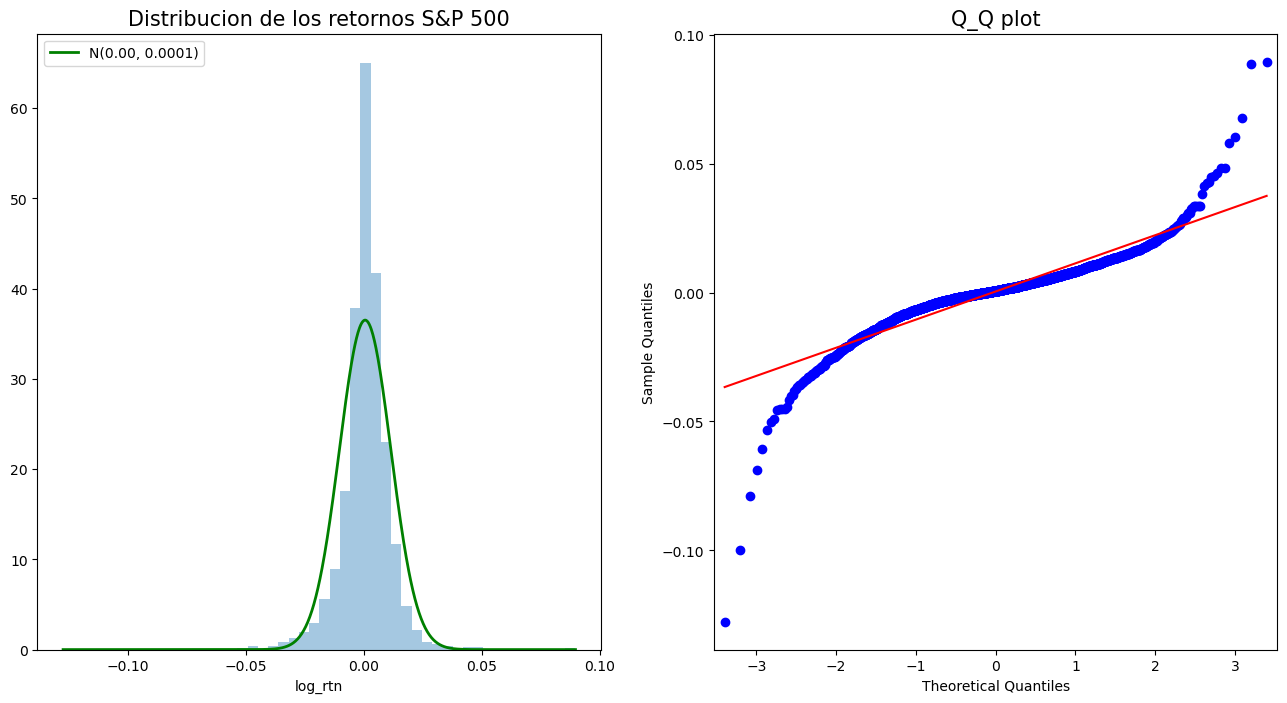

In [16]:
# Obtener indice de yahoo finance
"""Se usara el indice S&P 500 para realizar el ejercicio"""

## Obteniendo datos, seleccion de columna y renombre
df = yf.download("^GSPC", start="2010-01-01", end="2021-08-19", progress=False)
df = df.loc[:,["Adj Close"]].rename(columns={"Adj Close":"adj_close"})

## Calculo de retornos logaritmicos usando precios ajustados
df["log_rtn"] = np.log(df.adj_close / df.adj_close.shift(1))

## Limpia de datos vacios (NaN)
df = df[["adj_close","log_rtn"]].dropna(how="any")

## Calculo de funcion normal de densidad de probabilidad (Probability Density Function PDF)
### Se usa la media, desviacion estandar, y los retornos

r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean() # media
sigma = df.log_rtn.std() # desviacion estandar
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

##  Grafica de histograma y Q_Q
fig, ax = plt.subplots(1,2, figsize=(16,8)) # 1 fila 2 columnas

### Histograma
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribucion de los retornos S&P 500", fontsize=15)
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
            label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left")

### Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q_Q plot", fontsize=15)

plt.show()



